In [1]:
# 0. Import necessary libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [3]:
# 0. Load the dataset

INPUT_FOLDER = 'INPUT_FOLDER'
OUTPUT_FOLDER = 'OUTPUT_FOLDER'

base_csv = OUTPUT_FOLDER + '/output_reviews_top.csv'
df = pd.read_csv(base_csv)
df.head()

,Unnamed: 0,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [4]:
# 0. extract required columns
# create list of reviews, stars

review_list = df['text'].values
stars_list = df['stars'].values

In [37]:
# Map stars to sentiment

def map_sentiment(stars_received):
    if stars_received < 3:
        return 0
    elif stars_received >= 3:
        return 1

# Mapping stars to sentiment into three categories
# top_data_df['sentiment'] = [ map_sentiment(x) for x in top_data_df['stars']]

sentiment_list_int = [ map_sentiment(x) for x in stars_list]

print(len(stars_list), len(sentiment_list_int), len(review_list))

100000 100000 100000


In [38]:
X,y = df['text'].values,sentiment_list_int
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)

print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (75000,)
shape of test data is (25000,)


In [45]:
dd = pd.Series(y_train).value_counts()
print(dd.values)
print(dd)

[60818 14182]
1    60818
0    14182
dtype: int64


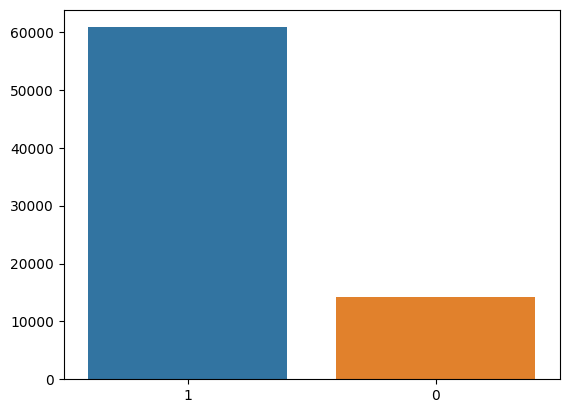

In [46]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['1','0']),y=dd.values)
plt.show()

In [47]:
x_train[:2]

array(["Nashville just wasn't the same without a bookstore like Parnassus! A welcome addition to our city!",
       "This place is all-show, no-go.  It looks nice and they are always in good locations.  But the food is average at best and usually downright mediocre.  I work at Thomas Jefferson Hospital and we often order lunch from Marathon Grill and it's always the same thing.... I think the menu description sounds great and the food never matches the description."],
      dtype=object)

In [48]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

# x_train: list of all reviews

def tockenize(reviews_train_list, review_test_list):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in reviews_train_list:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in reviews_train_list:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in review_test_list:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    return final_list_train, final_list_test, onehot_dict

In [49]:
x_train,x_test,vocab = tockenize(x_train,x_test)

In [50]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


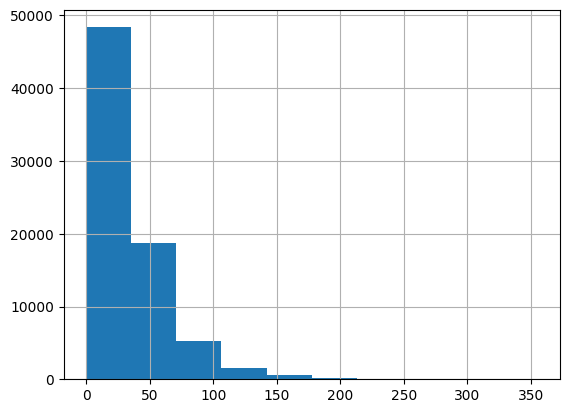

count    75000.000000
mean        35.777307
std         30.369549
min          0.000000
25%         16.000000
50%         27.000000
75%         45.000000
max        355.000000
dtype: float64

In [51]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [52]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [53]:
#we have very less number of reviews with length > 300.
#So we will consideronly those below it.
x_train_pad = padding_(x_train,300)
x_test_pad = padding_(x_test,300)

In [54]:
y_train = np.array(y_train)
print(y_train)

y_test = np.array(y_test)
print(y_test)


# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

[1 0 0 ... 0 1 1]
[1 1 1 ... 1 1 0]


In [55]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 300])
Sample input: 
 tensor([[  0,   0,   0,  ..., 650, 520, 452],
        [  0,   0,   0,  ...,  83,  68,  32],
        [  0,   0,   0,  ..., 280,   9, 120],
        ...,
        [  0,   0,   0,  ..., 578, 148, 159],
        [  0,   0,   0,  ...,  56,   4, 302],
        [  0,   0,   0,  ..., 745, 101, 241]])
Sample input: 
 tensor([0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1])


In [56]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,output_dim,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [57]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,output_dim,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [58]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

Training - 19mins, 3.4 seconds

In [59]:
# 12mins, 56 seconds

clip = 5
epochs = 1
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), 'models/sentiment_model.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

Epoch 1
train_loss : 0.29127252629896005 val_loss : 0.22586892867088318
train_accuracy : 87.91066666666667 val_accuracy : 90.52
Validation loss decreased (inf --> 0.225869).  Saving model ...


In [60]:
torch.save(model.state_dict(), 'models/sentiment_model.pt')

In [61]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())

In [63]:
index = 30
print(df['text'][index])
print('='*70)
print(f'Actual sentiment is  : {df["stars"][index]}')
print('='*70)
pro = predict_text(df['text'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

First time there and it was excellent!!! It feels like your are entering someone's home. The waiters there funny and nice. The food come out very quickly and it is phenomenal!!! Definitely will be going back to this place.
Actual sentiment is  : 5
Predicted sentiment is positive with a probability of 0.9539377689361572


In [64]:
index = 32
print(df['text'][index])
print('='*70)
print(f'Actual sentiment is  : {df["stars"][index]}')
print('='*70)
pro = predict_text(df['text'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'predicted sentiment is {status} with a probability of {pro}')

Great staff always helps and always nice. Always clean and huge store size. Stays stocked with everything you need. The staff always helps make my custom breakfast bagel
Actual sentiment is  : 5
predicted sentiment is positive with a probability of 0.9951086640357971


In [74]:
print("God save this place, never again! Hate it")
print('='*70)
print(f'Actual sentiment is  : 1')
print('='*70)
pro = predict_text("God save this place, never again! Hate it")
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'predicted sentiment is {status} with a probability of {pro}')

God save this place, never again! Hate it
Actual sentiment is  : 1
predicted sentiment is negative with a probability of 0.7129947245121002


In [72]:
print("Not a bad place!")
print('='*70)
print(f'Actual sentiment is  : 3')
print('='*70)
pro = predict_text("Not a bad place!")
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'predicted sentiment is {status} with a probability of {pro}')

Not a bad place!
Actual sentiment is  : 3
predicted sentiment is negative with a probability of 0.6785957217216492


In [73]:
print("Amazing Place!")
print('='*70)
print(f'Actual sentiment is  : 4')
print('='*70)
pro = predict_text("Amazing Place!")
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'predicted sentiment is {status} with a probability of {pro}')

Amazing Place!
Actual sentiment is  : 4
predicted sentiment is positive with a probability of 0.5468000173568726
